In [162]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from catboost import CatBoostRegressor

# Library data visualization
import plotly
import seaborn as sns
import numpy as np
import matplotlib.pylab as pl
import matplotlib as m
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import pyplot as plt

In [163]:
file_path = "/kaggle/input/predicta-1-0-predict-the-unpredictable/historical_weather.csv" 
df = pd.read_csv(file_path)

In [164]:
test_file_path = "/kaggle/input/predicta-1-0-predict-the-unpredictable/submission_key.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('submission_ID')

# Data Understanding and Preprocessing

In [165]:
df

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,C001,2014-01-01,6.6,-1.4,11.6,NaN,NaN,168.0,6.2
1,C001,2014-01-02,9.3,6.3,13.3,NaN,NaN,155.0,10.0
2,C001,2014-01-03,7.6,1.9,14.0,NaN,NaN,NaN,5.8
3,C001,2014-01-04,7.6,3.9,13.3,NaN,NaN,291.0,11.3
4,C001,2014-01-05,8.6,0.5,16.9,NaN,NaN,NaN,5.0
...,...,...,...,...,...,...,...,...,...
182333,C112,2018-12-27,22.0,15.9,27.9,0.0,NaN,100.0,13.2
182334,C112,2018-12-28,21.9,14.9,28.2,0.0,NaN,91.0,12.6
182335,C112,2018-12-29,22.4,16.3,28.2,0.0,NaN,61.0,14.2
182336,C112,2018-12-30,21.6,18.5,26.6,1.6,NaN,70.0,17.0


In [166]:
test_data

,city_id,date
0,C001,2019-01-01
1,C001,2019-01-02
2,C001,2019-01-03
3,C001,2019-01-04
4,C001,2019-01-05
...,...,...
695,C112,2019-01-03
696,C112,2019-01-04
697,C112,2019-01-05
698,C112,2019-01-06


In [167]:
df.nunique()

city_id                100
date                  1826
avg_temp_c             692
min_temp_c             720
max_temp_c             705
precipitation_mm       859
snow_depth_mm          407
avg_wind_dir_deg       361
avg_wind_speed_kmh     582
dtype: int64

In [168]:
def customDescription(df: pd.DataFrame, numeric_only: bool = False):
    if numeric_only:
        df = df.select_dtypes(include=np.number)
    
    desc = pd.DataFrame(index=df.columns.to_list())
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['null'] = df.isnull().sum()
    
    # Handle numeric columns separately
    if not df.select_dtypes(include=np.number).empty:
        numeric_desc = df.describe().T.drop(columns=['count','std','25%','50%','75%'], axis=1)
        for col in df.select_dtypes(include=np.number).columns:
            desc.loc[col, 'mean'] = numeric_desc.loc[col, 'mean']
            desc.loc[col, 'min'] = numeric_desc.loc[col, 'min']
            desc.loc[col, 'max'] = numeric_desc.loc[col, 'max']
    
    # Handle non-numeric columns separately
    if not df.select_dtypes(exclude=np.number).empty:
        non_numeric_desc = df.select_dtypes(exclude=np.number).describe().T
        desc = pd.concat([desc, non_numeric_desc.drop(columns=['count', 'unique', 'top', 'freq'], axis=1, errors='ignore')], axis=1)
    
    return desc

In [169]:
customDescription(df)

,type,count,nunique,null,mean,min,max
city_id,object,182338,100,0,NaN,NaN,NaN
date,object,182338,1826,0,NaN,NaN,NaN
avg_temp_c,float64,181114,692,1224,19.137516,-34.7,41.9
min_temp_c,float64,176452,720,5886,14.627775,-43.8,38.9
max_temp_c,float64,174845,705,7493,23.887261,-28.5,49.1
precipitation_mm,float64,112594,859,69744,3.679964,0.0,496.1
snow_depth_mm,float64,12238,407,170100,342.481696,0.0,7140.0
avg_wind_dir_deg,float64,146944,361,35394,175.650289,0.0,360.0
avg_wind_speed_kmh,float64,159866,582,22472,11.281875,0.0,80.0


In [170]:
# Step 1: Identify NaN rows in avg_temp_c
nan_rows = df[df['avg_temp_c'].isna()]

deleted_rows_count = 0

for index, row in nan_rows.iterrows():
    min_temp = row['min_temp_c']
    max_temp = row['max_temp_c']
    
    if pd.isna(min_temp) or pd.isna(max_temp):
        deleted_rows_count += 1
    else:
        df.at[index, 'avg_temp_c'] = (min_temp + max_temp) / 2

df.dropna(subset=['avg_temp_c'], inplace=True) 
print(f"Number of rows deleted: {deleted_rows_count}")

Number of rows deleted: 25


In [171]:
customDescription(df)

,type,count,nunique,null,mean,min,max
city_id,object,182313,100,0,NaN,NaN,NaN
date,object,182313,1826,0,NaN,NaN,NaN
avg_temp_c,float64,182313,1099,0,19.080045,-34.7,41.9
min_temp_c,float64,176441,720,5872,14.628773,-43.8,38.9
max_temp_c,float64,174843,705,7470,23.887492,-28.5,49.1
precipitation_mm,float64,112577,859,69736,3.680301,0.0,496.1
snow_depth_mm,float64,12229,407,170084,342.655246,0.0,7140.0
avg_wind_dir_deg,float64,146943,361,35370,175.650824,0.0,360.0
avg_wind_speed_kmh,float64,159859,582,22454,11.281575,0.0,80.0


In [172]:
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
new_df = df.drop(columns=['date'], axis=1)

In [173]:
new_df

,city_id,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,day,month,year
0,C001,6.6,-1.4,11.6,NaN,NaN,168.0,6.2,1,1,2014
1,C001,9.3,6.3,13.3,NaN,NaN,155.0,10.0,2,1,2014
2,C001,7.6,1.9,14.0,NaN,NaN,NaN,5.8,3,1,2014
3,C001,7.6,3.9,13.3,NaN,NaN,291.0,11.3,4,1,2014
4,C001,8.6,0.5,16.9,NaN,NaN,NaN,5.0,5,1,2014
...,...,...,...,...,...,...,...,...,...,...,...
182333,C112,22.0,15.9,27.9,0.0,NaN,100.0,13.2,27,12,2018
182334,C112,21.9,14.9,28.2,0.0,NaN,91.0,12.6,28,12,2018
182335,C112,22.4,16.3,28.2,0.0,NaN,61.0,14.2,29,12,2018
182336,C112,21.6,18.5,26.6,1.6,NaN,70.0,17.0,30,12,2018


In [174]:
new_df = new_df.drop(columns=['snow_depth_mm','precipitation_mm','avg_wind_dir_deg','avg_wind_speed_kmh'], axis=1)

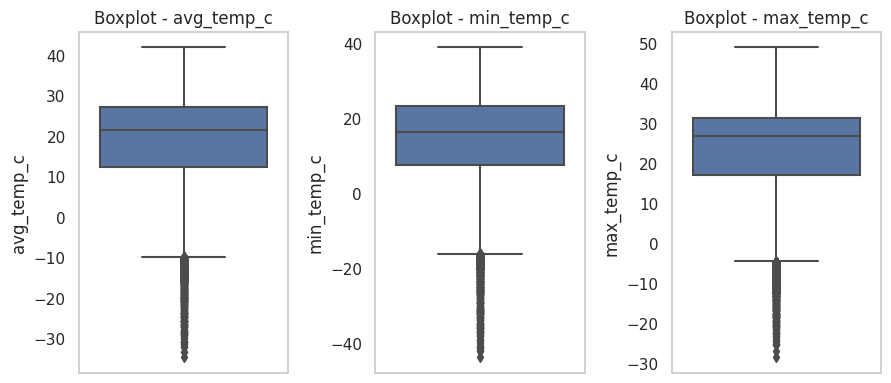

In [175]:
# Select numeric columns
numeric_columns = new_df.select_dtypes(include=['int64', 'float64'])

# Remove binary columns (columns with only two unique values)
columns_to_plot = numeric_columns.columns[numeric_columns.nunique() > 2]

# Calculate the number of rows and columns needed for subplots to fit all the columns
num_cols = 5  # Adjust the number of columns per row as needed
num_rows = int(np.ceil(len(columns_to_plot) / num_cols))

# Create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 4 * num_rows)) 

# Flatten the axes array in case of multiple rows
axes = axes.flatten()

# Iterate over the variables and plot the boxplots
for i, column in enumerate(columns_to_plot):
    sns.boxplot(y=df[column], ax=axes[i])
    axes[i].set_title(f"Boxplot - {column}")
    axes[i].grid(False)

# Remove empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout()
plt.show()

In [176]:
jan_days = [1, 2, 3, 4, 5, 6, 7,8]
dec_days = [22,23,24,25,26,27,28,29,30,31]

new_df = new_df[((new_df['month'] == 1) & (new_df['day'].isin(jan_days))) |
                 ((new_df['month'] == 12) & (new_df['day'].isin(dec_days)))]

In [177]:
from sklearn.preprocessing import LabelEncoder

# First, create label encoders for product_category and product_type
category_encoder = LabelEncoder()
type_encoder = LabelEncoder()

new_df['city_id'] = category_encoder.fit_transform(new_df['city_id'])

In [178]:
new_df

,city_id,avg_temp_c,min_temp_c,max_temp_c,day,month,year
0,0,6.6,-1.4,11.6,1,1,2014
1,0,9.3,6.3,13.3,2,1,2014
2,0,7.6,1.9,14.0,3,1,2014
3,0,7.6,3.9,13.3,4,1,2014
4,0,8.6,0.5,16.9,5,1,2014
...,...,...,...,...,...,...,...
182333,99,22.0,15.9,27.9,27,12,2018
182334,99,21.9,14.9,28.2,28,12,2018
182335,99,22.4,16.3,28.2,29,12,2018
182336,99,21.6,18.5,26.6,30,12,2018


In [179]:
customDescription(new_df)

,type,count,nunique,null,mean,min,max
city_id,int64,8985,100,0,49.463884,0.0,99.0
avg_temp_c,float64,8985,523,0,13.941603,-31.0,32.3
min_temp_c,float64,8718,503,267,10.046352,-37.2,28.5
max_temp_c,float64,8672,521,313,18.266167,-25.3,44.0
day,int32,8985,18,0,16.738230,1.0,31.0
month,int32,8985,2,0,7.118865,1.0,12.0
year,int32,8985,5,0,2016.003116,2014.0,2018.0


In [180]:
new_df

,city_id,avg_temp_c,min_temp_c,max_temp_c,day,month,year
0,0,6.6,-1.4,11.6,1,1,2014
1,0,9.3,6.3,13.3,2,1,2014
2,0,7.6,1.9,14.0,3,1,2014
3,0,7.6,3.9,13.3,4,1,2014
4,0,8.6,0.5,16.9,5,1,2014
...,...,...,...,...,...,...,...
182333,99,22.0,15.9,27.9,27,12,2018
182334,99,21.9,14.9,28.2,28,12,2018
182335,99,22.4,16.3,28.2,29,12,2018
182336,99,21.6,18.5,26.6,30,12,2018


# Feature Selection and Engineering

In [181]:
grouped = new_df.groupby(['city_id', 'day'])

stats = grouped['avg_temp_c'].agg(['mean', 'std']).reset_index()

def is_deviated(row, data):
    city_id, day, mean, std = row
    day_data = data[(data['city_id'] == city_id) & (data['day'] == day)]
    if len(day_data) > 1: 
        deviations = abs(day_data['avg_temp_c'] - mean) > (2 * std)
        return day_data[~deviations].index.tolist()
    return day_data.index.tolist()

valid_indices = []
for _, row in stats.iterrows():
    valid_indices.extend(is_deviated(row, new_df))

filtered_df = new_df.loc[valid_indices]

final_mean = filtered_df.groupby(['city_id', 'day'])['avg_temp_c'].mean().reset_index()

new_df = new_df.merge(final_mean, on=['city_id', 'day'], how='left', suffixes=('', '_mean_for_day_in_city'))
new_df.rename(columns={'avg_temp_c_mean_for_day_in_city': 'mean_temp_for_each_day_in_city'}, inplace=True)

In [182]:
grouped = new_df.groupby(['city_id', 'day'])

stats = grouped['min_temp_c'].agg(['mean', 'std']).reset_index()

def is_deviated(row, data):
    city_id, day, mean, std = row
    day_data = data[(data['city_id'] == city_id) & (data['day'] == day)]
    if len(day_data) > 1:  
        deviations = abs(day_data['min_temp_c'] - mean) > (2 * std)
        return day_data[~deviations].index.tolist()
    return day_data.index.tolist()

valid_indices = []
for _, row in stats.iterrows():
    valid_indices.extend(is_deviated(row, new_df))

filtered_df = new_df.loc[valid_indices]

final_mean = filtered_df.groupby(['city_id', 'day'])['min_temp_c'].mean().reset_index()

new_df = new_df.merge(final_mean, on=['city_id', 'day'], how='left', suffixes=('', '_mean_for_day_in_city'))

In [183]:
grouped = new_df.groupby(['city_id', 'day'])

stats = grouped['max_temp_c'].agg(['mean', 'std']).reset_index()

def is_deviated(row, data):
    city_id, day, mean, std = row
    day_data = data[(data['city_id'] == city_id) & (data['day'] == day)]
    if len(day_data) > 1:  
        deviations = abs(day_data['max_temp_c'] - mean) > (2 * std)
        return day_data[~deviations].index.tolist()
    return day_data.index.tolist()

valid_indices = []
for _, row in stats.iterrows():
    valid_indices.extend(is_deviated(row, new_df))

filtered_df = new_df.loc[valid_indices]

final_mean = filtered_df.groupby(['city_id', 'day'])['max_temp_c'].mean().reset_index()

new_df = new_df.merge(final_mean, on=['city_id', 'day'], how='left', suffixes=('', '_mean_for_day_in_city'))

### Visual EDA of the new feature

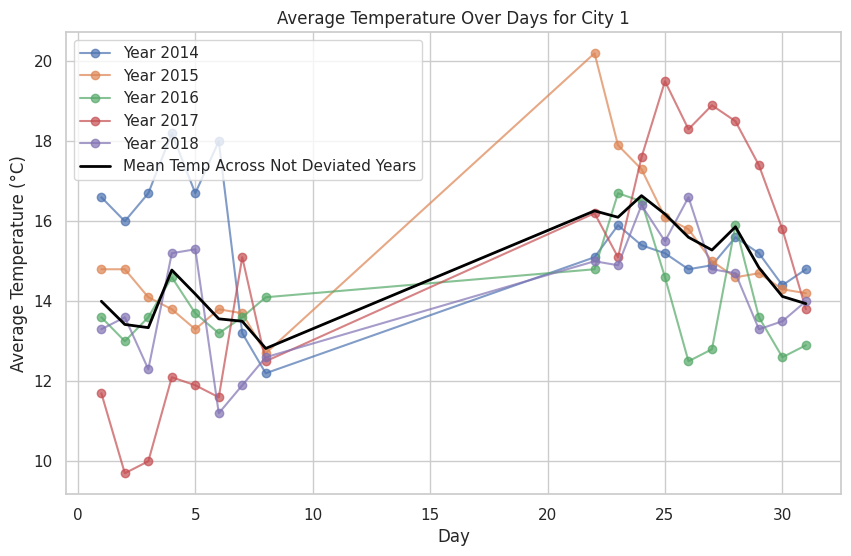

In [184]:
# Filter data for city_id 0
df_city_0 = new_df[new_df['city_id'] == 1]

# Calculate mean temperature for each day across all years
mean_temp_for_each_day = df_city_0.groupby('day')['avg_temp_c'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

# Plot data for each year
for year in df_city_0['year'].unique():
    df_year = df_city_0[df_city_0['year'] == year]
    plt.plot(df_year['day'], df_year['avg_temp_c'], marker='o', label=f"Year {year}", alpha=0.7)

# Plot mean temperature for each day
plt.plot(mean_temp_for_each_day['day'], mean_temp_for_each_day['avg_temp_c'], 
         color='black', linewidth=2, label='Mean Temp Across Not Deviated Years')

plt.xlabel('Day')
plt.ylabel('Average Temperature (°C)')
plt.title('Average Temperature Over Days for City 1')
plt.legend()
plt.grid(True)
plt.show()

In [185]:
customDescription(new_df)

,type,count,nunique,null,mean,min,max
city_id,int64,8985,100,0,49.463884,0.00,99.00
avg_temp_c,float64,8985,523,0,13.941603,-31.00,32.30
min_temp_c,float64,8718,503,267,10.046352,-37.20,28.50
max_temp_c,float64,8672,521,313,18.266167,-25.30,44.00
day,int32,8985,18,0,16.738230,1.00,31.00
month,int32,8985,2,0,7.118865,1.00,12.00
year,int32,8985,5,0,2016.003116,2014.00,2018.00
mean_temp_for_each_day_in_city,float64,8985,1084,0,13.941603,-19.26,29.20
min_temp_c_mean_for_day_in_city,float64,8985,1206,0,10.139569,-24.70,27.20
max_temp_c_mean_for_day_in_city,float64,8985,1128,0,18.292751,-13.76,35.35


In [186]:
new_df

,city_id,avg_temp_c,min_temp_c,max_temp_c,day,month,year,mean_temp_for_each_day_in_city,min_temp_c_mean_for_day_in_city,max_temp_c_mean_for_day_in_city
0,0,6.6,-1.4,11.6,1,1,2014,6.78,-0.20,14.56
1,0,9.3,6.3,13.3,2,1,2014,6.66,0.12,14.80
2,0,7.6,1.9,14.0,3,1,2014,7.62,1.90,14.62
3,0,7.6,3.9,13.3,4,1,2014,7.44,3.38,12.66
4,0,8.6,0.5,16.9,5,1,2014,7.56,1.60,14.24
...,...,...,...,...,...,...,...,...,...,...
8980,99,22.0,15.9,27.9,27,12,2018,22.88,17.18,28.60
8981,99,21.9,14.9,28.2,28,12,2018,23.48,17.12,28.60
8982,99,22.4,16.3,28.2,29,12,2018,22.46,17.62,28.10
8983,99,21.6,18.5,26.6,30,12,2018,21.70,17.38,27.88


In [187]:
new_df = new_df.drop(columns=['max_temp_c','min_temp_c'], axis=1)

In [188]:
new_df

,city_id,avg_temp_c,day,month,year,mean_temp_for_each_day_in_city,min_temp_c_mean_for_day_in_city,max_temp_c_mean_for_day_in_city
0,0,6.6,1,1,2014,6.78,-0.20,14.56
1,0,9.3,2,1,2014,6.66,0.12,14.80
2,0,7.6,3,1,2014,7.62,1.90,14.62
3,0,7.6,4,1,2014,7.44,3.38,12.66
4,0,8.6,5,1,2014,7.56,1.60,14.24
...,...,...,...,...,...,...,...,...
8980,99,22.0,27,12,2018,22.88,17.18,28.60
8981,99,21.9,28,12,2018,23.48,17.12,28.60
8982,99,22.4,29,12,2018,22.46,17.62,28.10
8983,99,21.6,30,12,2018,21.70,17.38,27.88


In [189]:
customDescription(new_df)

,type,count,nunique,null,mean,min,max
city_id,int64,8985,100,0,49.463884,0.00,99.00
avg_temp_c,float64,8985,523,0,13.941603,-31.00,32.30
day,int32,8985,18,0,16.738230,1.00,31.00
month,int32,8985,2,0,7.118865,1.00,12.00
year,int32,8985,5,0,2016.003116,2014.00,2018.00
mean_temp_for_each_day_in_city,float64,8985,1084,0,13.941603,-19.26,29.20
min_temp_c_mean_for_day_in_city,float64,8985,1206,0,10.139569,-24.70,27.20
max_temp_c_mean_for_day_in_city,float64,8985,1128,0,18.292751,-13.76,35.35


In [190]:
binary_cols=[]
#
for c in new_df.columns:
    if new_df[c].nunique() == 2:
        binary_cols.append(c)
#
num_cols = list(new_df.columns[np.where(new_df.dtypes != "object")[0]].drop(binary_cols))

In [191]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

mean_temp_for_each_day_in_city     1.455418
city_id                            1.435614
min_temp_c_mean_for_day_in_city    1.298463
max_temp_c_mean_for_day_in_city    1.203733
year                               0.005987
month                              0.004826
day                                0.004526
Name: MI Scores, dtype: float64


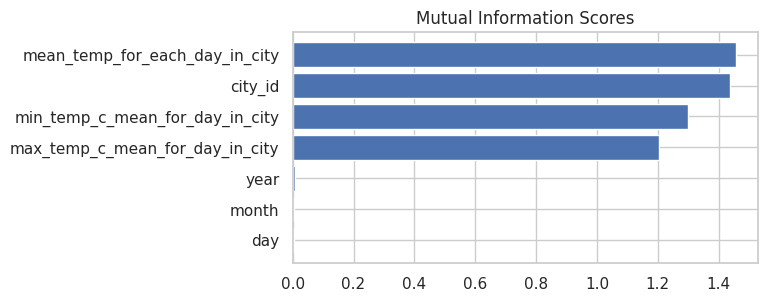

In [192]:
X = new_df.copy()
y = X.pop('avg_temp_c')

mi_scores = make_mi_scores(X, y)

print(mi_scores)
# print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(6, 3))
plot_mi_scores(mi_scores)
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

# Model Selection and Training

In [193]:
label = 'avg_temp_c' 
X = new_df.drop(columns=[label], axis=1)  
y = new_df[label] 

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5, test_size=0.1)

## Model 1 - GradientBoostedTreesModel

In [195]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([X_train, y_train], axis=1), label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([X_test, y_test], axis=1), label=label, task=tfdf.keras.Task.REGRESSION)

# Improved Model with Hyperparameter Tuning
model_1 = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.REGRESSION,
    num_trees=200,       # Increased trees for potential improvement
    growing_strategy="BEST_FIRST_GLOBAL",  # Explore alternative growing strategies
    max_depth=25,        # Tune this based on your data complexity
    l1_regularization=0.01,   # Add regularization to prevent overfitting
    l2_regularization=0.01,
    min_examples=2,     # Tune this
    shrinkage=0.1,       # Learning rate
    subsample=0.8,     # Add subsampling for potential improvement
    categorical_algorithm="RANDOM",  # Consider "HISTOGRAM" as well
    random_seed=3 
)

model_1.compile(metrics=["mse"])  

model_1.fit(x=train_ds, validation_data=test_ds)
evaluation = model_1.evaluate(test_ds, return_dict=True)
y_pred1 = model_1.predict(test_ds)
y_pred1 = y_pred1.squeeze()

rmse = np.sqrt(mean_squared_error(y_test, y_pred1))

print("\nModel Performance on Test Set:")
print(f"Root Mean Squared Error (RMSE): {rmse}")          
                                                         

Use /tmp/tmpond6azkz as temporary training directory
Reading training dataset...


[WARNING 24-06-24 15:23:43.7907 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-24 15:23:43.7908 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-24 15:23:43.7908 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.290592. Found 8086 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(899, shape=(), dtype=int32)
Validation dataset read in 0:00:00.254149. Found 899 examples.
Training model...
Model trained in 0:00:01.783670
Compiling model...
Model compiled.


[INFO 24-06-24 15:23:46.1091 UTC kernel.cc:1233] Loading model from path /tmp/tmpond6azkz/model/ with prefix 980789a1a29444a6
[INFO 24-06-24 15:23:46.1300 UTC quick_scorer_extended.cc:903] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-06-24 15:23:46.1312 UTC abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-24 15:23:46.1313 UTC kernel.cc:1061] Use fast generic engine


1/1 [==============================] - 0s 67ms/step

Model Performance on Test Set:
Root Mean Squared Error (RMSE): 2.281634992407375


## Model 2 - CatBoostRegressor

In [196]:
catb = CatBoostRegressor(iterations=1000, 
                         learning_rate=0.04, 
                         depth=8, 
                         l2_leaf_reg=6, 
                         bagging_temperature=0.8, 
                         early_stopping_rounds=50,
                         verbose=100)

model_2 = catb.fit(X_train, y_train, eval_set=(X_test, y_test))

y_pred10 = model_2.predict(X_test)
y_pred10 = y_pred10.squeeze()
rmse = np.sqrt(mean_squared_error(y_test, y_pred10))

print("\nModel Performance on Test Set:")
print(f"Root Mean Squared Error (RMSE): {rmse}")     

0:	learn: 11.3014071	test: 11.2005400	best: 11.2005400 (0)	total: 4ms	remaining: 4s
100:	learn: 2.4502502	test: 2.4043840	best: 2.4043840 (100)	total: 366ms	remaining: 3.26s
200:	learn: 2.2357910	test: 2.2575395	best: 2.2575395 (200)	total: 725ms	remaining: 2.88s
300:	learn: 2.1281818	test: 2.2058819	best: 2.2058819 (300)	total: 1.08s	remaining: 2.52s
400:	learn: 2.0331309	test: 2.1738812	best: 2.1738812 (400)	total: 1.44s	remaining: 2.15s
500:	learn: 1.9522148	test: 2.1441712	best: 2.1441712 (500)	total: 1.8s	remaining: 1.8s
600:	learn: 1.8803812	test: 2.1215769	best: 2.1214663 (598)	total: 2.2s	remaining: 1.46s
700:	learn: 1.8159963	test: 2.1078393	best: 2.1078393 (700)	total: 2.56s	remaining: 1.09s
800:	learn: 1.7585845	test: 2.0981906	best: 2.0976748 (795)	total: 2.92s	remaining: 726ms
900:	learn: 1.7066984	test: 2.0904107	best: 2.0904107 (900)	total: 3.29s	remaining: 361ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.087150971
bestIteration = 929

Shrink mod

# Preparing test data set

In [197]:
test_data

,city_id,date
0,C001,2019-01-01
1,C001,2019-01-02
2,C001,2019-01-03
3,C001,2019-01-04
4,C001,2019-01-05
...,...,...
695,C112,2019-01-03
696,C112,2019-01-04
697,C112,2019-01-05
698,C112,2019-01-06


In [198]:
customDescription(test_data)

,type,count,nunique,null
city_id,object,700,100,0
date,object,700,7,0


In [199]:
new_df

,city_id,avg_temp_c,day,month,year,mean_temp_for_each_day_in_city,min_temp_c_mean_for_day_in_city,max_temp_c_mean_for_day_in_city
0,0,6.6,1,1,2014,6.78,-0.20,14.56
1,0,9.3,2,1,2014,6.66,0.12,14.80
2,0,7.6,3,1,2014,7.62,1.90,14.62
3,0,7.6,4,1,2014,7.44,3.38,12.66
4,0,8.6,5,1,2014,7.56,1.60,14.24
...,...,...,...,...,...,...,...,...
8980,99,22.0,27,12,2018,22.88,17.18,28.60
8981,99,21.9,28,12,2018,23.48,17.12,28.60
8982,99,22.4,29,12,2018,22.46,17.62,28.10
8983,99,21.6,30,12,2018,21.70,17.38,27.88


In [200]:
test_data['city_id'] = category_encoder.fit_transform(test_data['city_id'])

test_data['date'] = pd.to_datetime(test_data['date'])
test_data['day'] = test_data['date'].dt.day
test_data['month'] = test_data['date'].dt.month
test_data['year'] = test_data['date'].dt.year
test_data = test_data.drop(columns=['date'], axis=1)

In [201]:
test_data

,city_id,day,month,year
0,0,1,1,2019
1,0,2,1,2019
2,0,3,1,2019
3,0,4,1,2019
4,0,5,1,2019
...,...,...,...,...
695,99,3,1,2019
696,99,4,1,2019
697,99,5,1,2019
698,99,6,1,2019


In [202]:
unique_combinations = new_df[['city_id', 'day', 'mean_temp_for_each_day_in_city']].drop_duplicates()
test_data = test_data.merge(unique_combinations, on=['city_id', 'day'], how='left')

unique_combinations = new_df[['city_id', 'day', 'min_temp_c_mean_for_day_in_city']].drop_duplicates()
test_data = test_data.merge(unique_combinations, on=['city_id', 'day'], how='left')

unique_combinations = new_df[['city_id', 'day', 'max_temp_c_mean_for_day_in_city']].drop_duplicates()
test_data = test_data.merge(unique_combinations, on=['city_id', 'day'], how='left')

test_data.drop_duplicates()

,city_id,day,month,year,mean_temp_for_each_day_in_city,min_temp_c_mean_for_day_in_city,max_temp_c_mean_for_day_in_city
0,0,1,1,2019,6.780,-0.200,14.560
1,0,2,1,2019,6.660,0.120,14.800
2,0,3,1,2019,7.620,1.900,14.620
3,0,4,1,2019,7.440,3.380,12.660
4,0,5,1,2019,7.560,1.600,14.240
...,...,...,...,...,...,...,...
695,99,3,1,2019,21.925,16.850,27.250
696,99,4,1,2019,21.525,16.675,25.325
697,99,5,1,2019,22.225,17.900,25.725
698,99,6,1,2019,22.275,18.275,25.575


In [203]:
new_df

,city_id,avg_temp_c,day,month,year,mean_temp_for_each_day_in_city,min_temp_c_mean_for_day_in_city,max_temp_c_mean_for_day_in_city
0,0,6.6,1,1,2014,6.78,-0.20,14.56
1,0,9.3,2,1,2014,6.66,0.12,14.80
2,0,7.6,3,1,2014,7.62,1.90,14.62
3,0,7.6,4,1,2014,7.44,3.38,12.66
4,0,8.6,5,1,2014,7.56,1.60,14.24
...,...,...,...,...,...,...,...,...
8980,99,22.0,27,12,2018,22.88,17.18,28.60
8981,99,21.9,28,12,2018,23.48,17.12,28.60
8982,99,22.4,29,12,2018,22.46,17.62,28.10
8983,99,21.6,30,12,2018,21.70,17.38,27.88


In [204]:
test_data

,city_id,day,month,year,mean_temp_for_each_day_in_city,min_temp_c_mean_for_day_in_city,max_temp_c_mean_for_day_in_city
0,0,1,1,2019,6.780,-0.200,14.560
1,0,2,1,2019,6.660,0.120,14.800
2,0,3,1,2019,7.620,1.900,14.620
3,0,4,1,2019,7.440,3.380,12.660
4,0,5,1,2019,7.560,1.600,14.240
...,...,...,...,...,...,...,...
695,99,3,1,2019,21.925,16.850,27.250
696,99,4,1,2019,21.525,16.675,25.325
697,99,5,1,2019,22.225,17.900,25.725
698,99,6,1,2019,22.275,18.275,25.575


# Outputs

In [205]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data,task = tfdf.keras.Task.REGRESSION)
preds = model_1.predict(test_ds)

output = pd.DataFrame({'submission_ID': ids,
                       'avg_temp_c': preds.squeeze()})

output.to_csv("Outpu1.csv", index=False)

1/1 [==============================] - 0s 71ms/step


In [206]:
preds = model_2.predict(test_data)

output = pd.DataFrame({'submission_ID': ids,
                       'avg_temp_c': preds.squeeze()})

output.to_csv("Outpu2.csv", index=False)

# Prophet Model

In [147]:
df

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,day,month,year
0,C001,2014-01-01,6.6,-1.4,11.6,NaN,NaN,168.0,6.2,1,1,2014
1,C001,2014-01-02,9.3,6.3,13.3,NaN,NaN,155.0,10.0,2,1,2014
2,C001,2014-01-03,7.6,1.9,14.0,NaN,NaN,NaN,5.8,3,1,2014
3,C001,2014-01-04,7.6,3.9,13.3,NaN,NaN,291.0,11.3,4,1,2014
4,C001,2014-01-05,8.6,0.5,16.9,NaN,NaN,NaN,5.0,5,1,2014
...,...,...,...,...,...,...,...,...,...,...,...,...
182333,C112,2018-12-27,22.0,15.9,27.9,0.0,NaN,100.0,13.2,27,12,2018
182334,C112,2018-12-28,21.9,14.9,28.2,0.0,NaN,91.0,12.6,28,12,2018
182335,C112,2018-12-29,22.4,16.3,28.2,0.0,NaN,61.0,14.2,29,12,2018
182336,C112,2018-12-30,21.6,18.5,26.6,1.6,NaN,70.0,17.0,30,12,2018


In [148]:
len(df['city_id'].unique())
cities = []
for c in new_df['city_id'].unique():
    cities.append(str(c))

In [149]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

encoded_cities = encoder.fit_transform(df[['city_id']]).toarray()
df[cities] = encoded_cities

/tmp/ipykernel_33/3744183372.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cities] = encoded_cities
/tmp/ipykernel_33/3744183372.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cities] = encoded_cities
/tmp/ipykernel_33/3744183372.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df

In [150]:
df['city_avg_temp_for_month'] = df.groupby(['city_id', 'year', 'month'])['avg_temp_c'].transform('mean')
df['city_avg_max_temp_for_month'] = df.groupby(['city_id', 'year', 'month'])['avg_temp_c'].transform('max')
df['city_avg_min_temp_for_month'] = df.groupby(['city_id', 'year', 'month'])['avg_temp_c'].transform('min')

/tmp/ipykernel_33/804369557.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['city_avg_temp_for_month'] = df.groupby(['city_id', 'year', 'month'])['avg_temp_c'].transform('mean')
/tmp/ipykernel_33/804369557.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['city_avg_max_temp_for_month'] = df.groupby(['city_id', 'year', 'month'])['avg_temp_c'].transform('max')
/tmp/ipykernel_33/804369557.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

In [151]:
df = df.drop(columns=['max_temp_c','min_temp_c','snow_depth_mm','precipitation_mm','avg_wind_dir_deg','avg_wind_speed_kmh'], axis=1)

In [153]:
new_df1 = df.copy()
new_df1['moving_avg_temp'] = new_df1['avg_temp_c'].rolling(window = 7,center = True,min_periods=3).mean()

In [154]:
new_df1['moving_avg_temp'].isna().sum()

0

15:31:04 - cmdstanpy - INFO - Chain [1] start processing
15:31:05 - cmdstanpy - INFO - Chain [1] done processing
15:31:05 - cmdstanpy - INFO - Chain [1] start processing
15:31:05 - cmdstanpy - INFO - Chain [1] done processing
15:31:06 - cmdstanpy - INFO - Chain [1] start processing
15:31:06 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_33/2010048163.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  yearly_data.loc[len(yearly_data)] = [np.nan] * yearly_data.shape[1]
/tmp/ipykernel_33/2010048163.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old

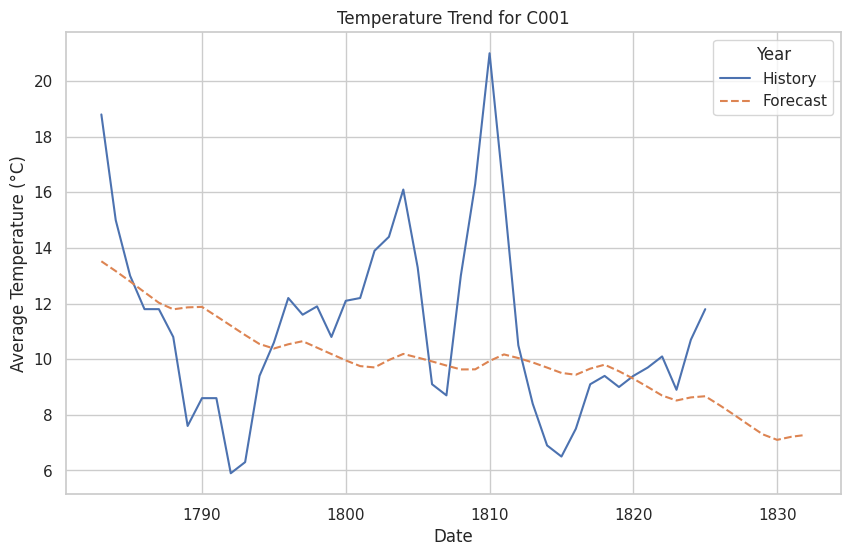

15:31:08 - cmdstanpy - INFO - Chain [1] start processing
15:31:08 - cmdstanpy - INFO - Chain [1] done processing
15:31:08 - cmdstanpy - INFO - Chain [1] start processing
15:31:09 - cmdstanpy - INFO - Chain [1] done processing
15:31:09 - cmdstanpy - INFO - Chain [1] start processing
15:31:10 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_33/2010048163.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  yearly_data.loc[len(yearly_data)] = [np.nan] * yearly_data.shape[1]
/tmp/ipykernel_33/2010048163.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old

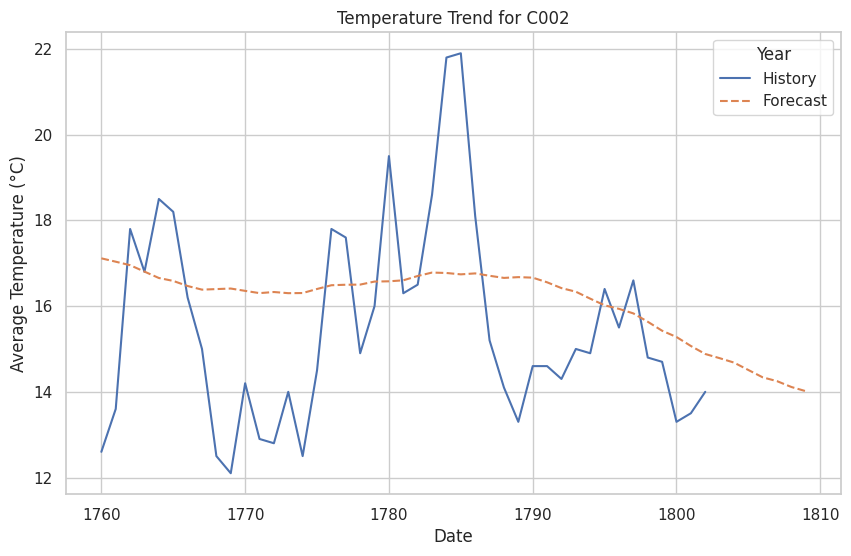

15:31:11 - cmdstanpy - INFO - Chain [1] start processing
15:31:12 - cmdstanpy - INFO - Chain [1] done processing
15:31:12 - cmdstanpy - INFO - Chain [1] start processing
15:31:13 - cmdstanpy - INFO - Chain [1] done processing
15:31:14 - cmdstanpy - INFO - Chain [1] start processing
15:31:15 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_33/2010048163.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  yearly_data.loc[len(yearly_data)] = [np.nan] * yearly_data.shape[1]
/tmp/ipykernel_33/2010048163.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old

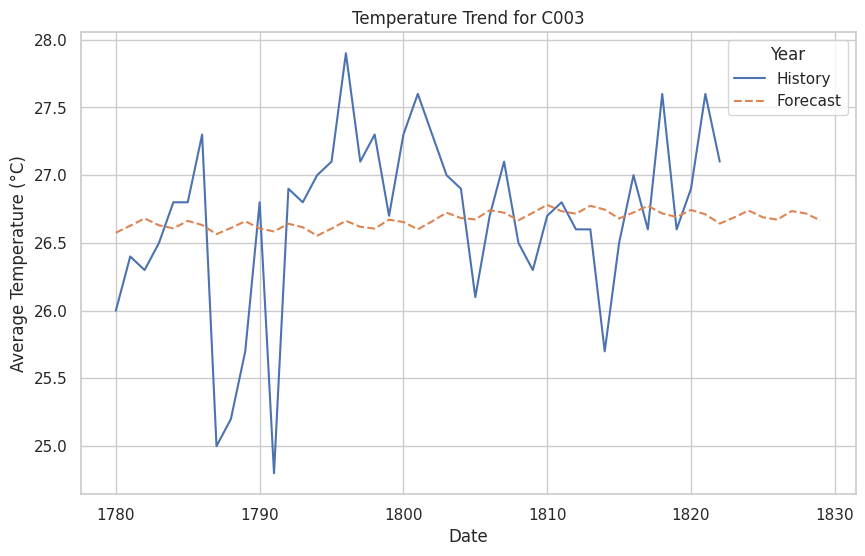

15:31:16 - cmdstanpy - INFO - Chain [1] start processing
15:31:16 - cmdstanpy - INFO - Chain [1] done processing
15:31:17 - cmdstanpy - INFO - Chain [1] start processing
15:31:17 - cmdstanpy - INFO - Chain [1] done processing
15:31:18 - cmdstanpy - INFO - Chain [1] start processing
15:31:18 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_33/2010048163.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  yearly_data.loc[len(yearly_data)] = [np.nan] * yearly_data.shape[1]
/tmp/ipykernel_33/2010048163.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old

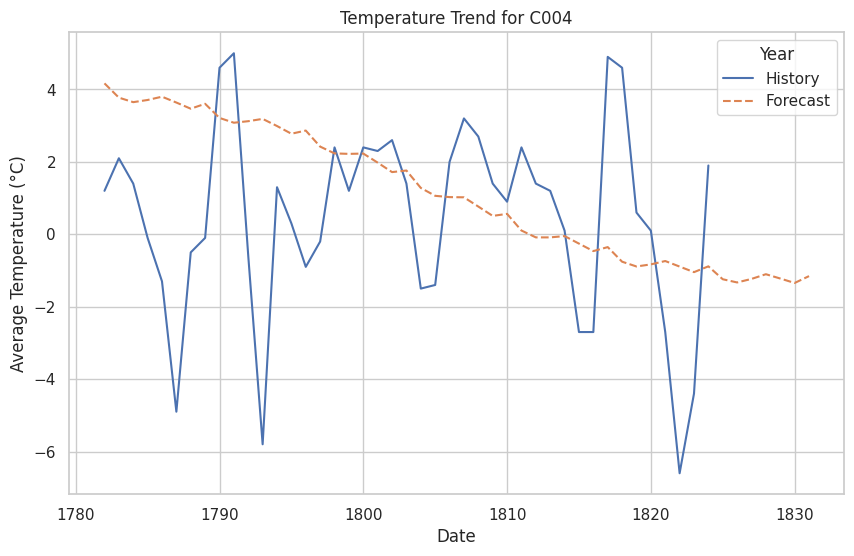

15:31:20 - cmdstanpy - INFO - Chain [1] start processing
15:31:20 - cmdstanpy - INFO - Chain [1] done processing
15:31:20 - cmdstanpy - INFO - Chain [1] start processing
15:31:20 - cmdstanpy - INFO - Chain [1] done processing
15:31:21 - cmdstanpy - INFO - Chain [1] start processing
15:31:22 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_33/2010048163.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  yearly_data.loc[len(yearly_data)] = [np.nan] * yearly_data.shape[1]
/tmp/ipykernel_33/2010048163.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old

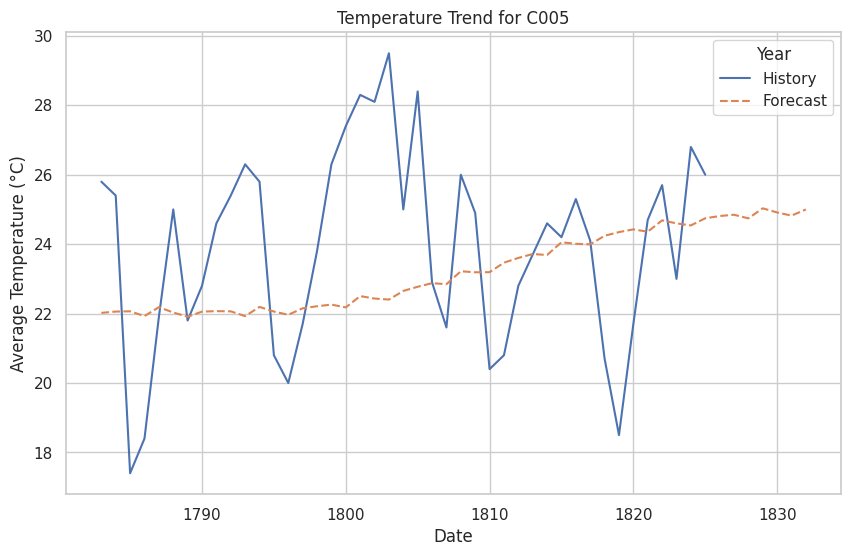

In [212]:
from prophet import Prophet

def forecast_future_with_prophet_regressors(city_data1,col):
    city_data1 = city_data1.sort_values(by='date')
    
    # Prepare data for Prophet
    city_data1 = city_data1.rename(columns={'date': 'ds', col: 'y'})
    
    # Initialize and fit the Prophet model
    model1 = Prophet()
    
    model1.fit(city_data1[['ds', 'y']])
    
    # Create a DataFrame for future dates
    future_dates1 = model1.make_future_dataframe(periods=7)
    
    # Predict future values
    forecast1 = model1.predict(future_dates1)
    
    return forecast1.set_index('ds')['yhat']

# Function to forecast future 7 days using Prophet
def forecast_future_with_prophet(city_data):
    city_fu = city_data.copy()
    city_data = city_data.sort_values(by='date')
    
    # Prepare data for Prophet
    city_data = city_data.rename(columns={'date': 'ds', 'avg_temp_c': 'y'})
    
    # Initialize and fit the Prophet model
    model = Prophet()
    
    # Fit the model with the additional regressor
    model.add_regressor('moving_avg_temp')
    
    model.fit(city_data[['ds', 'y','moving_avg_temp']])
    
    # Create a DataFrame for future dates
    future_dates = model.make_future_dataframe(periods=7)
    #future_dates['moving_avg_temp'] = forecast_future_with_prophet_regressors(city_fu,'moving_avg_temp')
    y =forecast_future_with_prophet_regressors(city_fu,'moving_avg_temp')
    y.name = 'moving_avg_temp'
    
    # Predict moving average temperature for future dates
    y = forecast_future_with_prophet_regressors(city_fu, 'moving_avg_temp')
    y.name = 'moving_avg_temp'
    
    # Combine future dates with predicted moving average temperature
    future_dates = future_dates.set_index('ds')
    future_dates = future_dates.join(y, how='left')
    
    # Check for and handle NaN values in future_dates['moving_avg_temp']
    if future_dates['moving_avg_temp'].isna().sum() > 0:
        print("NaNs found in 'moving_avg_temp'. Please ensure the future moving average temperatures are correctly provided.")
        future_dates['moving_avg_temp'].fillna(method='ffill', inplace=True)  # or handle appropriately
    
    # Predict future values
    forecast = model.predict(future_dates.reset_index())
    
    return forecast.set_index('ds')['yhat']

sns.set(style="whitegrid")

start = '12-31'
end = '01-07'

new_df2=new_df1.copy()

display='avg_temp_c'

cities = new_df2['city_id'].unique()
for city in cities[:5]:
    plt.figure(figsize=(10, 6))
    city_data = new_df2[new_df2['city_id'] == city]
    
    y_forecast = forecast_future_with_prophet(city_data)
    
    # Plot data for each year in a different color
    
    yearly_data = city_data.copy()
    
    
    for i in range(7):
        yearly_data.loc[len(yearly_data)] = [np.nan] * yearly_data.shape[1]
    yearly_data['index'] = np.arange(len(yearly_data.index))
    pl = yearly_data[-50:]
    plt.plot(pl['index'], pl[display], label='History')
    plt.plot(pl['index'], y_forecast[-50:], label='Forecast', linestyle='dashed')
    
    plt.title(f'Temperature Trend for {city}')
    plt.xlabel('Date')
    plt.ylabel('Average Temperature (°C)')
    plt.legend(title='Year')
    plt.show()

In [157]:
final_data3 = pd.read_csv('/kaggle/input/predicta-1-0-predict-the-unpredictable/submission_key.csv')
final_data3['date'] = pd.to_datetime(final_data3['date'])
final_data3['avg_temp_c'] = np.nan 

final_data3.head()

,submission_ID,city_id,date,avg_temp_c
0,1,C001,2019-01-01,NaN
1,2,C001,2019-01-02,NaN
2,3,C001,2019-01-03,NaN
3,4,C001,2019-01-04,NaN
4,5,C001,2019-01-05,NaN


### With Regressors (Moving Average)

* We tried with other features using as regressors, but the best accuracy scored by **only with the moving average as a regressor**

In [158]:
from prophet import Prophet

def forecast_future_with_prophet_regressors(city_data1,col):
    city_data1 = city_data1.sort_values(by='date')
    
    # Prepare data for Prophet
    city_data1 = city_data1.rename(columns={'date': 'ds', col: 'y'})
    
    # Initialize and fit the Prophet model
    model1 = Prophet()
    
    model1.fit(city_data1[['ds', 'y']])
    
    # Create a DataFrame for future dates
    future_dates1 = model1.make_future_dataframe(periods=7)
    
    # Predict future values
    forecast1 = model1.predict(future_dates1)
    
    return forecast1.set_index('ds')['yhat']

# Function to forecast future 7 days using Prophet
def forecast_future_with_prophet(city_data):
    city_fu = city_data.copy()
    city_data = city_data.sort_values(by='date')
    
    # Prepare data for Prophet
    city_data = city_data.rename(columns={'date': 'ds', 'avg_temp_c': 'y'})
    
    # Initialize and fit the Prophet model
    model = Prophet()
    
    # Fit the model with the additional regressor
    model.add_regressor('moving_avg_temp')
    #model.add_regressor('city_avg_temp_for_month')
    
    model.fit(city_data[['ds', 'y','moving_avg_temp']])
    
    # Create a DataFrame for future dates
    future_dates = model.make_future_dataframe(periods=7)
    #future_dates['moving_avg_temp'] = forecast_future_with_prophet_regressors(city_fu,'moving_avg_temp')
    y =forecast_future_with_prophet_regressors(city_fu,'moving_avg_temp')
    y.name = 'moving_avg_temp'
    
    # Combine future dates with predicted moving average temperature
    future_dates = future_dates.set_index('ds')
    future_dates = future_dates.join(y, how='left')
    
    # Check for and handle NaN values in future_dates['moving_avg_temp']
    if future_dates['moving_avg_temp'].isna().sum() > 0:
        print("NaNs found in 'moving_avg_temp'. Please ensure the future moving average temperatures are correctly provided.")
        future_dates['moving_avg_temp'].fillna(method='ffill', inplace=True)  # or handle appropriately
    
    
    #Code for testing with other features as regressors ; --Failed
    
    # Predict city_avg_temp_for_month for future dates
    #y = forecast_future_with_prophet_regressors(city_fu, 'city_avg_temp_for_month')
    #y.name = 'city_avg_temp_for_month'
    
    # Combine future dates with predicted city_avg_temp_for_month
    #future_dates = future_dates.join(y, how='left')
    
    # Check for and handle NaN values in future_dates['city_avg_temp_for_month']
    #if future_dates['city_avg_temp_for_month'].isna().sum() > 0:
    #    print("NaNs found in 'city_avg_temp_for_month'. Please ensure the future city_avg_temp_for_month are correctly provided.")
    #    future_dates['city_avg_temp_for_month'].fillna(method='ffill', inplace=True)  # or handle appropriately
    
    
    # Predict future values
    forecast = model.predict(future_dates.reset_index())
    
    return forecast.set_index('ds')['yhat']


start_date = '2019-01-01'
end_date = '2019-01-07'

new_df2=new_df1.copy()

cities = new_df2['city_id'].unique()
for city in cities:
    city_data = new_df2[new_df2['city_id'] == city]
    
    y_forecast = forecast_future_with_prophet(city_data)
    print(city)
    
    # Update the avg_temp for the specified city_id and date range
    final_data3.loc[(final_data3['city_id'] == city) & (final_data3['date'] >= start_date) & (final_data3['date'] <= end_date), 'avg_temp_c'] = y_forecast[-7:].values
final_data3[:8]



15:17:28 - cmdstanpy - INFO - Chain [1] start processing
15:17:28 - cmdstanpy - INFO - Chain [1] done processing
15:17:28 - cmdstanpy - INFO - Chain [1] start processing
15:17:28 - cmdstanpy - INFO - Chain [1] done processing
15:17:30 - cmdstanpy - INFO - Chain [1] start processing


C001


15:17:30 - cmdstanpy - INFO - Chain [1] done processing
15:17:30 - cmdstanpy - INFO - Chain [1] start processing
15:17:31 - cmdstanpy - INFO - Chain [1] done processing
15:17:32 - cmdstanpy - INFO - Chain [1] start processing


C002


15:17:32 - cmdstanpy - INFO - Chain [1] done processing
15:17:32 - cmdstanpy - INFO - Chain [1] start processing
15:17:33 - cmdstanpy - INFO - Chain [1] done processing
15:17:35 - cmdstanpy - INFO - Chain [1] start processing


C003


15:17:35 - cmdstanpy - INFO - Chain [1] done processing
15:17:35 - cmdstanpy - INFO - Chain [1] start processing
15:17:36 - cmdstanpy - INFO - Chain [1] done processing
15:17:37 - cmdstanpy - INFO - Chain [1] start processing


C004


15:17:37 - cmdstanpy - INFO - Chain [1] done processing
15:17:37 - cmdstanpy - INFO - Chain [1] start processing
15:17:37 - cmdstanpy - INFO - Chain [1] done processing
15:17:39 - cmdstanpy - INFO - Chain [1] start processing


C005


15:17:39 - cmdstanpy - INFO - Chain [1] done processing
15:17:39 - cmdstanpy - INFO - Chain [1] start processing
15:17:39 - cmdstanpy - INFO - Chain [1] done processing
15:17:41 - cmdstanpy - INFO - Chain [1] start processing


C007


15:17:41 - cmdstanpy - INFO - Chain [1] done processing
15:17:41 - cmdstanpy - INFO - Chain [1] start processing
15:17:41 - cmdstanpy - INFO - Chain [1] done processing
15:17:43 - cmdstanpy - INFO - Chain [1] start processing


C008


15:17:43 - cmdstanpy - INFO - Chain [1] done processing
15:17:43 - cmdstanpy - INFO - Chain [1] start processing
15:17:44 - cmdstanpy - INFO - Chain [1] done processing
15:17:46 - cmdstanpy - INFO - Chain [1] start processing


C009


15:17:46 - cmdstanpy - INFO - Chain [1] done processing
15:17:46 - cmdstanpy - INFO - Chain [1] start processing
15:17:46 - cmdstanpy - INFO - Chain [1] done processing
15:17:48 - cmdstanpy - INFO - Chain [1] start processing


C010


15:17:48 - cmdstanpy - INFO - Chain [1] done processing
15:17:48 - cmdstanpy - INFO - Chain [1] start processing
15:17:48 - cmdstanpy - INFO - Chain [1] done processing
15:17:50 - cmdstanpy - INFO - Chain [1] start processing


C011


15:17:50 - cmdstanpy - INFO - Chain [1] done processing
15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:17:50 - cmdstanpy - INFO - Chain [1] done processing
15:17:52 - cmdstanpy - INFO - Chain [1] start processing


C012


15:17:52 - cmdstanpy - INFO - Chain [1] done processing
15:17:52 - cmdstanpy - INFO - Chain [1] start processing
15:17:52 - cmdstanpy - INFO - Chain [1] done processing
15:17:54 - cmdstanpy - INFO - Chain [1] start processing


C013


15:17:54 - cmdstanpy - INFO - Chain [1] done processing
15:17:54 - cmdstanpy - INFO - Chain [1] start processing
15:17:54 - cmdstanpy - INFO - Chain [1] done processing
15:17:55 - cmdstanpy - INFO - Chain [1] start processing


C014


15:17:56 - cmdstanpy - INFO - Chain [1] done processing
15:17:56 - cmdstanpy - INFO - Chain [1] start processing
15:17:56 - cmdstanpy - INFO - Chain [1] done processing
15:17:58 - cmdstanpy - INFO - Chain [1] start processing


C015


15:17:58 - cmdstanpy - INFO - Chain [1] done processing
15:17:58 - cmdstanpy - INFO - Chain [1] start processing
15:17:59 - cmdstanpy - INFO - Chain [1] done processing
15:18:00 - cmdstanpy - INFO - Chain [1] start processing


C016


15:18:00 - cmdstanpy - INFO - Chain [1] done processing
15:18:00 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing
15:18:02 - cmdstanpy - INFO - Chain [1] start processing


C017


15:18:03 - cmdstanpy - INFO - Chain [1] done processing
15:18:03 - cmdstanpy - INFO - Chain [1] start processing
15:18:03 - cmdstanpy - INFO - Chain [1] done processing
15:18:05 - cmdstanpy - INFO - Chain [1] start processing


C018


15:18:05 - cmdstanpy - INFO - Chain [1] done processing
15:18:05 - cmdstanpy - INFO - Chain [1] start processing
15:18:05 - cmdstanpy - INFO - Chain [1] done processing
15:18:07 - cmdstanpy - INFO - Chain [1] start processing


C020


15:18:07 - cmdstanpy - INFO - Chain [1] done processing
15:18:07 - cmdstanpy - INFO - Chain [1] start processing
15:18:07 - cmdstanpy - INFO - Chain [1] done processing
15:18:09 - cmdstanpy - INFO - Chain [1] start processing


C022


15:18:09 - cmdstanpy - INFO - Chain [1] done processing
15:18:09 - cmdstanpy - INFO - Chain [1] start processing
15:18:10 - cmdstanpy - INFO - Chain [1] done processing
15:18:11 - cmdstanpy - INFO - Chain [1] start processing


C023


15:18:11 - cmdstanpy - INFO - Chain [1] done processing
15:18:11 - cmdstanpy - INFO - Chain [1] start processing
15:18:12 - cmdstanpy - INFO - Chain [1] done processing
15:18:13 - cmdstanpy - INFO - Chain [1] start processing


C024


15:18:13 - cmdstanpy - INFO - Chain [1] done processing
15:18:13 - cmdstanpy - INFO - Chain [1] start processing
15:18:14 - cmdstanpy - INFO - Chain [1] done processing
15:18:15 - cmdstanpy - INFO - Chain [1] start processing


C025


15:18:15 - cmdstanpy - INFO - Chain [1] done processing
15:18:16 - cmdstanpy - INFO - Chain [1] start processing
15:18:16 - cmdstanpy - INFO - Chain [1] done processing
15:18:17 - cmdstanpy - INFO - Chain [1] start processing


C027


15:18:18 - cmdstanpy - INFO - Chain [1] done processing
15:18:18 - cmdstanpy - INFO - Chain [1] start processing
15:18:19 - cmdstanpy - INFO - Chain [1] done processing
15:18:20 - cmdstanpy - INFO - Chain [1] start processing


C028


15:18:20 - cmdstanpy - INFO - Chain [1] done processing
15:18:20 - cmdstanpy - INFO - Chain [1] start processing
15:18:21 - cmdstanpy - INFO - Chain [1] done processing
15:18:23 - cmdstanpy - INFO - Chain [1] start processing


C029


15:18:23 - cmdstanpy - INFO - Chain [1] done processing
15:18:23 - cmdstanpy - INFO - Chain [1] start processing
15:18:24 - cmdstanpy - INFO - Chain [1] done processing
15:18:25 - cmdstanpy - INFO - Chain [1] start processing


C030


15:18:25 - cmdstanpy - INFO - Chain [1] done processing
15:18:25 - cmdstanpy - INFO - Chain [1] start processing
15:18:26 - cmdstanpy - INFO - Chain [1] done processing
15:18:27 - cmdstanpy - INFO - Chain [1] start processing


C031


15:18:28 - cmdstanpy - INFO - Chain [1] done processing
15:18:28 - cmdstanpy - INFO - Chain [1] start processing
15:18:28 - cmdstanpy - INFO - Chain [1] done processing
15:18:30 - cmdstanpy - INFO - Chain [1] start processing


C033


15:18:30 - cmdstanpy - INFO - Chain [1] done processing
15:18:30 - cmdstanpy - INFO - Chain [1] start processing
15:18:30 - cmdstanpy - INFO - Chain [1] done processing
15:18:32 - cmdstanpy - INFO - Chain [1] start processing


C034


15:18:32 - cmdstanpy - INFO - Chain [1] done processing
15:18:32 - cmdstanpy - INFO - Chain [1] start processing
15:18:33 - cmdstanpy - INFO - Chain [1] done processing
15:18:34 - cmdstanpy - INFO - Chain [1] start processing


C035


15:18:35 - cmdstanpy - INFO - Chain [1] done processing
15:18:35 - cmdstanpy - INFO - Chain [1] start processing
15:18:35 - cmdstanpy - INFO - Chain [1] done processing
15:18:36 - cmdstanpy - INFO - Chain [1] start processing


C036


15:18:37 - cmdstanpy - INFO - Chain [1] done processing
15:18:37 - cmdstanpy - INFO - Chain [1] start processing
15:18:37 - cmdstanpy - INFO - Chain [1] done processing
15:18:39 - cmdstanpy - INFO - Chain [1] start processing


C037


15:18:39 - cmdstanpy - INFO - Chain [1] done processing
15:18:39 - cmdstanpy - INFO - Chain [1] start processing
15:18:40 - cmdstanpy - INFO - Chain [1] done processing
15:18:41 - cmdstanpy - INFO - Chain [1] start processing


C038


15:18:41 - cmdstanpy - INFO - Chain [1] done processing
15:18:41 - cmdstanpy - INFO - Chain [1] start processing
15:18:41 - cmdstanpy - INFO - Chain [1] done processing
15:18:43 - cmdstanpy - INFO - Chain [1] start processing


C039


15:18:43 - cmdstanpy - INFO - Chain [1] done processing
15:18:43 - cmdstanpy - INFO - Chain [1] start processing
15:18:44 - cmdstanpy - INFO - Chain [1] done processing
15:18:46 - cmdstanpy - INFO - Chain [1] start processing


C040


15:18:46 - cmdstanpy - INFO - Chain [1] done processing
15:18:46 - cmdstanpy - INFO - Chain [1] start processing
15:18:47 - cmdstanpy - INFO - Chain [1] done processing
15:18:49 - cmdstanpy - INFO - Chain [1] start processing


C042


15:18:49 - cmdstanpy - INFO - Chain [1] done processing
15:18:49 - cmdstanpy - INFO - Chain [1] start processing
15:18:49 - cmdstanpy - INFO - Chain [1] done processing
15:18:50 - cmdstanpy - INFO - Chain [1] start processing


C043


15:18:51 - cmdstanpy - INFO - Chain [1] done processing
15:18:51 - cmdstanpy - INFO - Chain [1] start processing
15:18:51 - cmdstanpy - INFO - Chain [1] done processing
15:18:53 - cmdstanpy - INFO - Chain [1] start processing


C044


15:18:53 - cmdstanpy - INFO - Chain [1] done processing
15:18:53 - cmdstanpy - INFO - Chain [1] start processing
15:18:54 - cmdstanpy - INFO - Chain [1] done processing
15:18:55 - cmdstanpy - INFO - Chain [1] start processing


C045


15:18:55 - cmdstanpy - INFO - Chain [1] done processing
15:18:55 - cmdstanpy - INFO - Chain [1] start processing
15:18:56 - cmdstanpy - INFO - Chain [1] done processing
15:18:57 - cmdstanpy - INFO - Chain [1] start processing


C046


15:18:57 - cmdstanpy - INFO - Chain [1] done processing
15:18:57 - cmdstanpy - INFO - Chain [1] start processing
15:18:58 - cmdstanpy - INFO - Chain [1] done processing
15:18:59 - cmdstanpy - INFO - Chain [1] start processing


C047


15:19:00 - cmdstanpy - INFO - Chain [1] done processing
15:19:00 - cmdstanpy - INFO - Chain [1] start processing
15:19:00 - cmdstanpy - INFO - Chain [1] done processing
15:19:01 - cmdstanpy - INFO - Chain [1] start processing


C048


15:19:01 - cmdstanpy - INFO - Chain [1] done processing
15:19:02 - cmdstanpy - INFO - Chain [1] start processing
15:19:02 - cmdstanpy - INFO - Chain [1] done processing
15:19:03 - cmdstanpy - INFO - Chain [1] start processing


C049


15:19:04 - cmdstanpy - INFO - Chain [1] done processing
15:19:04 - cmdstanpy - INFO - Chain [1] start processing
15:19:05 - cmdstanpy - INFO - Chain [1] done processing
15:19:06 - cmdstanpy - INFO - Chain [1] start processing


C051


15:19:06 - cmdstanpy - INFO - Chain [1] done processing
15:19:06 - cmdstanpy - INFO - Chain [1] start processing
15:19:07 - cmdstanpy - INFO - Chain [1] done processing
15:19:08 - cmdstanpy - INFO - Chain [1] start processing


C053


15:19:09 - cmdstanpy - INFO - Chain [1] done processing
15:19:09 - cmdstanpy - INFO - Chain [1] start processing
15:19:09 - cmdstanpy - INFO - Chain [1] done processing
15:19:10 - cmdstanpy - INFO - Chain [1] start processing


C054


15:19:10 - cmdstanpy - INFO - Chain [1] done processing
15:19:11 - cmdstanpy - INFO - Chain [1] start processing
15:19:11 - cmdstanpy - INFO - Chain [1] done processing
15:19:12 - cmdstanpy - INFO - Chain [1] start processing


C055


15:19:13 - cmdstanpy - INFO - Chain [1] done processing
15:19:13 - cmdstanpy - INFO - Chain [1] start processing
15:19:13 - cmdstanpy - INFO - Chain [1] done processing
15:19:14 - cmdstanpy - INFO - Chain [1] start processing


C056


15:19:15 - cmdstanpy - INFO - Chain [1] done processing
15:19:15 - cmdstanpy - INFO - Chain [1] start processing
15:19:15 - cmdstanpy - INFO - Chain [1] done processing
15:19:17 - cmdstanpy - INFO - Chain [1] start processing


C057


15:19:17 - cmdstanpy - INFO - Chain [1] done processing
15:19:17 - cmdstanpy - INFO - Chain [1] start processing
15:19:17 - cmdstanpy - INFO - Chain [1] done processing
15:19:19 - cmdstanpy - INFO - Chain [1] start processing


C058


15:19:19 - cmdstanpy - INFO - Chain [1] done processing
15:19:19 - cmdstanpy - INFO - Chain [1] start processing
15:19:20 - cmdstanpy - INFO - Chain [1] done processing
15:19:21 - cmdstanpy - INFO - Chain [1] start processing


C059


15:19:21 - cmdstanpy - INFO - Chain [1] done processing
15:19:22 - cmdstanpy - INFO - Chain [1] start processing
15:19:22 - cmdstanpy - INFO - Chain [1] done processing
15:19:24 - cmdstanpy - INFO - Chain [1] start processing


C061


15:19:24 - cmdstanpy - INFO - Chain [1] done processing
15:19:24 - cmdstanpy - INFO - Chain [1] start processing
15:19:24 - cmdstanpy - INFO - Chain [1] done processing
15:19:25 - cmdstanpy - INFO - Chain [1] start processing


C062


15:19:26 - cmdstanpy - INFO - Chain [1] done processing
15:19:26 - cmdstanpy - INFO - Chain [1] start processing
15:19:26 - cmdstanpy - INFO - Chain [1] done processing
15:19:28 - cmdstanpy - INFO - Chain [1] start processing


C064


15:19:28 - cmdstanpy - INFO - Chain [1] done processing
15:19:28 - cmdstanpy - INFO - Chain [1] start processing
15:19:28 - cmdstanpy - INFO - Chain [1] done processing
15:19:30 - cmdstanpy - INFO - Chain [1] start processing


C065


15:19:30 - cmdstanpy - INFO - Chain [1] done processing
15:19:30 - cmdstanpy - INFO - Chain [1] start processing
15:19:31 - cmdstanpy - INFO - Chain [1] done processing
15:19:32 - cmdstanpy - INFO - Chain [1] start processing


C066


15:19:32 - cmdstanpy - INFO - Chain [1] done processing
15:19:33 - cmdstanpy - INFO - Chain [1] start processing
15:19:33 - cmdstanpy - INFO - Chain [1] done processing
15:19:34 - cmdstanpy - INFO - Chain [1] start processing


C067


15:19:34 - cmdstanpy - INFO - Chain [1] done processing
15:19:35 - cmdstanpy - INFO - Chain [1] start processing
15:19:35 - cmdstanpy - INFO - Chain [1] done processing
15:19:37 - cmdstanpy - INFO - Chain [1] start processing


C068


15:19:37 - cmdstanpy - INFO - Chain [1] done processing
15:19:37 - cmdstanpy - INFO - Chain [1] start processing
15:19:37 - cmdstanpy - INFO - Chain [1] done processing
15:19:39 - cmdstanpy - INFO - Chain [1] start processing


C069


15:19:39 - cmdstanpy - INFO - Chain [1] done processing
15:19:39 - cmdstanpy - INFO - Chain [1] start processing
15:19:40 - cmdstanpy - INFO - Chain [1] done processing
15:19:41 - cmdstanpy - INFO - Chain [1] start processing


C070


15:19:41 - cmdstanpy - INFO - Chain [1] done processing
15:19:41 - cmdstanpy - INFO - Chain [1] start processing
15:19:42 - cmdstanpy - INFO - Chain [1] done processing
15:19:44 - cmdstanpy - INFO - Chain [1] start processing


C071


15:19:44 - cmdstanpy - INFO - Chain [1] done processing
15:19:44 - cmdstanpy - INFO - Chain [1] start processing
15:19:44 - cmdstanpy - INFO - Chain [1] done processing
15:19:45 - cmdstanpy - INFO - Chain [1] start processing


C072


15:19:46 - cmdstanpy - INFO - Chain [1] done processing
15:19:46 - cmdstanpy - INFO - Chain [1] start processing
15:19:46 - cmdstanpy - INFO - Chain [1] done processing
15:19:47 - cmdstanpy - INFO - Chain [1] start processing


C073


15:19:48 - cmdstanpy - INFO - Chain [1] done processing
15:19:48 - cmdstanpy - INFO - Chain [1] start processing
15:19:49 - cmdstanpy - INFO - Chain [1] done processing
15:19:50 - cmdstanpy - INFO - Chain [1] start processing


C074


15:19:50 - cmdstanpy - INFO - Chain [1] done processing
15:19:50 - cmdstanpy - INFO - Chain [1] start processing
15:19:51 - cmdstanpy - INFO - Chain [1] done processing
15:19:52 - cmdstanpy - INFO - Chain [1] start processing


C076


15:19:53 - cmdstanpy - INFO - Chain [1] done processing
15:19:53 - cmdstanpy - INFO - Chain [1] start processing
15:19:53 - cmdstanpy - INFO - Chain [1] done processing
15:19:54 - cmdstanpy - INFO - Chain [1] start processing


C077


15:19:54 - cmdstanpy - INFO - Chain [1] done processing
15:19:55 - cmdstanpy - INFO - Chain [1] start processing
15:19:55 - cmdstanpy - INFO - Chain [1] done processing
15:19:57 - cmdstanpy - INFO - Chain [1] start processing


C078


15:19:57 - cmdstanpy - INFO - Chain [1] done processing
15:19:57 - cmdstanpy - INFO - Chain [1] start processing
15:19:57 - cmdstanpy - INFO - Chain [1] done processing
15:19:59 - cmdstanpy - INFO - Chain [1] start processing


C079


15:19:59 - cmdstanpy - INFO - Chain [1] done processing
15:19:59 - cmdstanpy - INFO - Chain [1] start processing
15:19:59 - cmdstanpy - INFO - Chain [1] done processing
15:20:01 - cmdstanpy - INFO - Chain [1] start processing


C081


15:20:01 - cmdstanpy - INFO - Chain [1] done processing
15:20:01 - cmdstanpy - INFO - Chain [1] start processing
15:20:02 - cmdstanpy - INFO - Chain [1] done processing
15:20:04 - cmdstanpy - INFO - Chain [1] start processing


C082


15:20:04 - cmdstanpy - INFO - Chain [1] done processing
15:20:04 - cmdstanpy - INFO - Chain [1] start processing
15:20:05 - cmdstanpy - INFO - Chain [1] done processing
15:20:06 - cmdstanpy - INFO - Chain [1] start processing


C083


15:20:06 - cmdstanpy - INFO - Chain [1] done processing
15:20:07 - cmdstanpy - INFO - Chain [1] start processing
15:20:07 - cmdstanpy - INFO - Chain [1] done processing
15:20:08 - cmdstanpy - INFO - Chain [1] start processing


C084


15:20:09 - cmdstanpy - INFO - Chain [1] done processing
15:20:09 - cmdstanpy - INFO - Chain [1] start processing
15:20:09 - cmdstanpy - INFO - Chain [1] done processing
15:20:10 - cmdstanpy - INFO - Chain [1] start processing


C085


15:20:11 - cmdstanpy - INFO - Chain [1] done processing
15:20:11 - cmdstanpy - INFO - Chain [1] start processing
15:20:11 - cmdstanpy - INFO - Chain [1] done processing
15:20:13 - cmdstanpy - INFO - Chain [1] start processing


C086


15:20:13 - cmdstanpy - INFO - Chain [1] done processing
15:20:13 - cmdstanpy - INFO - Chain [1] start processing
15:20:13 - cmdstanpy - INFO - Chain [1] done processing
15:20:15 - cmdstanpy - INFO - Chain [1] start processing


C087


15:20:15 - cmdstanpy - INFO - Chain [1] done processing
15:20:15 - cmdstanpy - INFO - Chain [1] start processing
15:20:16 - cmdstanpy - INFO - Chain [1] done processing
15:20:17 - cmdstanpy - INFO - Chain [1] start processing


C088


15:20:17 - cmdstanpy - INFO - Chain [1] done processing
15:20:18 - cmdstanpy - INFO - Chain [1] start processing
15:20:18 - cmdstanpy - INFO - Chain [1] done processing
15:20:19 - cmdstanpy - INFO - Chain [1] start processing


C089


15:20:20 - cmdstanpy - INFO - Chain [1] done processing
15:20:20 - cmdstanpy - INFO - Chain [1] start processing
15:20:20 - cmdstanpy - INFO - Chain [1] done processing
15:20:22 - cmdstanpy - INFO - Chain [1] start processing


C090


15:20:22 - cmdstanpy - INFO - Chain [1] done processing
15:20:22 - cmdstanpy - INFO - Chain [1] start processing
15:20:23 - cmdstanpy - INFO - Chain [1] done processing
15:20:24 - cmdstanpy - INFO - Chain [1] start processing


C091


15:20:24 - cmdstanpy - INFO - Chain [1] done processing
15:20:24 - cmdstanpy - INFO - Chain [1] start processing
15:20:25 - cmdstanpy - INFO - Chain [1] done processing
15:20:26 - cmdstanpy - INFO - Chain [1] start processing


C092


15:20:26 - cmdstanpy - INFO - Chain [1] done processing
15:20:26 - cmdstanpy - INFO - Chain [1] start processing
15:20:27 - cmdstanpy - INFO - Chain [1] done processing
15:20:28 - cmdstanpy - INFO - Chain [1] start processing


C093


15:20:29 - cmdstanpy - INFO - Chain [1] done processing
15:20:29 - cmdstanpy - INFO - Chain [1] start processing
15:20:29 - cmdstanpy - INFO - Chain [1] done processing
15:20:30 - cmdstanpy - INFO - Chain [1] start processing


C094


15:20:31 - cmdstanpy - INFO - Chain [1] done processing
15:20:31 - cmdstanpy - INFO - Chain [1] start processing
15:20:32 - cmdstanpy - INFO - Chain [1] done processing
15:20:33 - cmdstanpy - INFO - Chain [1] start processing


C095


15:20:34 - cmdstanpy - INFO - Chain [1] done processing
15:20:34 - cmdstanpy - INFO - Chain [1] start processing
15:20:34 - cmdstanpy - INFO - Chain [1] done processing
15:20:35 - cmdstanpy - INFO - Chain [1] start processing


C096


15:20:35 - cmdstanpy - INFO - Chain [1] done processing
15:20:36 - cmdstanpy - INFO - Chain [1] start processing
15:20:36 - cmdstanpy - INFO - Chain [1] done processing
15:20:37 - cmdstanpy - INFO - Chain [1] start processing


C097


15:20:38 - cmdstanpy - INFO - Chain [1] done processing
15:20:38 - cmdstanpy - INFO - Chain [1] start processing
15:20:38 - cmdstanpy - INFO - Chain [1] done processing
15:20:39 - cmdstanpy - INFO - Chain [1] start processing


C098


15:20:40 - cmdstanpy - INFO - Chain [1] done processing
15:20:40 - cmdstanpy - INFO - Chain [1] start processing
15:20:40 - cmdstanpy - INFO - Chain [1] done processing
15:20:42 - cmdstanpy - INFO - Chain [1] start processing


C099


15:20:42 - cmdstanpy - INFO - Chain [1] done processing
15:20:42 - cmdstanpy - INFO - Chain [1] start processing
15:20:42 - cmdstanpy - INFO - Chain [1] done processing
15:20:44 - cmdstanpy - INFO - Chain [1] start processing


C100


15:20:44 - cmdstanpy - INFO - Chain [1] done processing
15:20:44 - cmdstanpy - INFO - Chain [1] start processing
15:20:45 - cmdstanpy - INFO - Chain [1] done processing
15:20:46 - cmdstanpy - INFO - Chain [1] start processing
15:20:46 - cmdstanpy - INFO - Chain [1] done processing


C101


15:20:47 - cmdstanpy - INFO - Chain [1] start processing
15:20:47 - cmdstanpy - INFO - Chain [1] done processing
15:20:48 - cmdstanpy - INFO - Chain [1] start processing


C102


15:20:49 - cmdstanpy - INFO - Chain [1] done processing
15:20:49 - cmdstanpy - INFO - Chain [1] start processing
15:20:49 - cmdstanpy - INFO - Chain [1] done processing
15:20:50 - cmdstanpy - INFO - Chain [1] start processing


C103


15:20:51 - cmdstanpy - INFO - Chain [1] done processing
15:20:51 - cmdstanpy - INFO - Chain [1] start processing
15:20:51 - cmdstanpy - INFO - Chain [1] done processing
15:20:53 - cmdstanpy - INFO - Chain [1] start processing


C104


15:20:53 - cmdstanpy - INFO - Chain [1] done processing
15:20:53 - cmdstanpy - INFO - Chain [1] start processing
15:20:53 - cmdstanpy - INFO - Chain [1] done processing
15:20:55 - cmdstanpy - INFO - Chain [1] start processing


C105


15:20:55 - cmdstanpy - INFO - Chain [1] done processing
15:20:55 - cmdstanpy - INFO - Chain [1] start processing
15:20:56 - cmdstanpy - INFO - Chain [1] done processing
15:20:57 - cmdstanpy - INFO - Chain [1] start processing


C106


15:20:57 - cmdstanpy - INFO - Chain [1] done processing
15:20:58 - cmdstanpy - INFO - Chain [1] start processing
15:20:58 - cmdstanpy - INFO - Chain [1] done processing
15:20:59 - cmdstanpy - INFO - Chain [1] start processing


C107


15:20:59 - cmdstanpy - INFO - Chain [1] done processing
15:20:59 - cmdstanpy - INFO - Chain [1] start processing
15:21:00 - cmdstanpy - INFO - Chain [1] done processing
15:21:01 - cmdstanpy - INFO - Chain [1] start processing


C108


15:21:01 - cmdstanpy - INFO - Chain [1] done processing
15:21:02 - cmdstanpy - INFO - Chain [1] start processing
15:21:02 - cmdstanpy - INFO - Chain [1] done processing
15:21:03 - cmdstanpy - INFO - Chain [1] start processing


C109


15:21:03 - cmdstanpy - INFO - Chain [1] done processing
15:21:03 - cmdstanpy - INFO - Chain [1] start processing
15:21:04 - cmdstanpy - INFO - Chain [1] done processing
15:21:05 - cmdstanpy - INFO - Chain [1] start processing


C110


15:21:06 - cmdstanpy - INFO - Chain [1] done processing
15:21:06 - cmdstanpy - INFO - Chain [1] start processing
15:21:07 - cmdstanpy - INFO - Chain [1] done processing
15:21:08 - cmdstanpy - INFO - Chain [1] start processing


C111


15:21:09 - cmdstanpy - INFO - Chain [1] done processing
15:21:09 - cmdstanpy - INFO - Chain [1] start processing
15:21:09 - cmdstanpy - INFO - Chain [1] done processing


C112


,submission_ID,city_id,date,avg_temp_c
0,1,C001,2019-01-01,8.345784
1,2,C001,2019-01-02,8.003321
2,3,C001,2019-01-03,7.646276
3,4,C001,2019-01-04,7.298595
4,5,C001,2019-01-05,7.100393
5,6,C001,2019-01-06,7.212808
6,7,C001,2019-01-07,7.278134
7,8,C002,2019-01-01,14.785262


In [161]:
output_prop = final_data3.drop(columns=['city_id','date'],axis=1)
output_prop.to_csv('Outpu3.csv',index=False)

# Blending

In [207]:
from scipy import stats

blenders = ["Outpu1.csv","Outpu2.csv","Outpu3.csv"]

def read_blenders(blenders):
    return [pd.read_csv(blender) for blender in blenders]


predictions = read_blenders(blenders)

In [215]:
results = pd.DataFrame()
for i, ds in enumerate(predictions):
    results[f'model {i+1}'] = ds['avg_temp_c']

print(results.shape)
results.head()

(700, 3)


,model 1,model 2,model 3
0,8.925576,9.856776,8.345784
1,8.561995,9.667099,8.003321
2,9.566690,10.619466,7.646276
3,10.553263,11.366525,7.298595
4,10.461246,10.722516,7.100393


In [210]:
import pandas as pd
from scipy.stats import mode

# Load submission file
SUB_F = pd.read_csv("/kaggle/input/predicta-1-0-predict-the-unpredictable/sample_submission.csv")

# Load predictions from competition notebooks
first = pd.read_csv('Outpu1.csv')['avg_temp_c']
second = pd.read_csv('Outpu2.csv')['avg_temp_c']
third = pd.read_csv('Outpu3.csv')['avg_temp_c']

# Concatenate predictions
Pred = pd.concat([first, second, third], axis=1)

# Blending
Blend = Pred.mode(axis=1)
Blend = Blend.iloc[:, 0]

# Create submission dataframe
SUB_B = pd.DataFrame({"submission_ID": SUB_F.submission_ID, 'avg_temp_c': Blend})

SUB_B

,submission_ID,avg_temp_c
0,1,8.345784
1,2,8.003321
2,3,7.646276
3,4,7.298595
4,5,7.100393
...,...,...
695,696,21.088542
696,697,20.568637
697,698,21.022413
698,699,21.120768


In [211]:
# Save the blended predictions to a CSV file
SUB_B.to_csv("Submission.csv", index=False)